In [42]:
import os
import time
import numpy as np
from astropy import units
from astropy.coordinates import Angle

from pyuvdata import UVData

from bda import bda_tools
import importlib
# importlib.reload(bda_tools)

import matplotlib.pyplot as plt

In [13]:
def get_times_use(file_in, fraction_of_times):
    uv = UVData()
    uv.read(file_in, read_data=False)
    unique_times = np.unique(uv.time_array)
    n_times = unique_times.size
    
    return unique_times[:int(round(n_times *fraction_of_times))]


In [3]:
def apply_bda(file_in, file_out, pre_fs_int_time=0.1, corr_FoV_angle=20.0,
              max_time=30, corr_int_time=None, max_decorr=0.1, overwrite=False, filetype='uvh5',
              times_use=None):

    if os.path.exists(file_out) and overwrite is False:
        raise ValueError("{} exists. Use --overwrite to overwrite the file.".format(file_out))

    # check that output filetype is valid
    if filetype not in ("uvh5", "uvfits", "miriad"):
        raise ValueError("filetype must be one of uvh5, uvfits, or miriad")

    uv = UVData()
    uv.read(file_in, times=times_use)

    # apply BDA
    pre_fs_int_time = pre_fs_int_time * units.s
    corr_FoV_angle = Angle(corr_FoV_angle, units.deg)
    max_time = max_time * units.s
    uv2 = bda_tools.apply_bda(
        uv,
        max_decorr,
        pre_fs_int_time,
        corr_FoV_angle,
        max_time,
        corr_int_time,
    )

    # write out file
    if filetype == "uvh5":
        uv2.write_uvh5(file_out, clobber=True)
    if filetype == "uvfits":
        uv2.write_uvfits(file_out, spoof_nonessential=True, force_phase=True)
    if filetype == "miriad":
        uv2.write_miriad(file_out, clobber=True)


In [4]:
uvfits_file_in = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform.uvfits'
uvh5_file_in = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform.uvh5'
uvh5_file_in_fixed = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform_fixed.uvh5'
if not os.path.isfile(uvh5_file_in_fixed):
    t0 = time.time()
    uv_in = UVData()
    print_str = 'time to read in '
    if not os.path.isfile(uvh5_file_in):
        uv_in.read(uvfits_file_in)
        print_str += 'uvfits file '
    else:
        uv_in.read(uvh5_file_in)
        print_str += 'uvh5 file '
        
    if min(uv_in.integration_time) < 0.9:
        # simulation files were originally written with int time in days not seconds
        uv_in.integration_time = uv_in.integration_time * 3600 * 24
        uv_in.set_lsts_from_time_array()

    if uv_in.phase_type == 'phased':
        uv_in.unphase_to_drift()
        
    uv_in.write_uvh5(uvh5_file_in_fixed)
    t1 = time.time()
    
    print_str += 'and fix it: {t} seconds'.format(t=t1-t0)
    print(print_str)

In [23]:
fraction_times_use = 0.1
short_file = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform_fixed_' + str(fraction_times_use) + '.uvh5'
if not os.path.isfile(short_file):
    times_use = get_times_use(file_in, fraction_times_use)
    uv_in = UVData()
    uv_in.read(uvh5_file_in_fixed, times=times_use)
    uv_in.write_uvh5(short_file)

In [24]:
file_in=short_file
file_in_basename, file_extension = os.path.splitext(os.path.basename(file_in))
file_out='/Volumes/Data1/bda_outputs/' + file_in_basename + '_bda.uvh5'
initial_int_time=1.0  # seconds

In [25]:
if not os.path.isfile(file_out):
    t0 = time.time()
    apply_bda(file_in, file_out, pre_fs_int_time=initial_int_time, corr_FoV_angle=20.0,
              max_time=30, corr_int_time=None, overwrite=False, filetype='uvh5')
    t1 = time.time()
    print('time to read file into a uvdata object and do bda: {t} seconds'.format(t=t1-t0))

averaging baseline  (0, 0)
averaging 1 time samples...


averaging baseline  (1, 0)
averaging 9 time samples...
averaging baseline  (1, 1)
averaging 1 time samples...
averaging baseline  (2, 0)
averaging 9 time samples...
averaging baseline  (2, 1)
averaging 8 time samples...
averaging baseline  (2, 2)
averaging 1 time samples...
averaging baseline  (3, 0)
averaging 9 time samples...
averaging baseline  (3, 1)
averaging 9 time samples...
averaging baseline  (3, 2)
averaging 9 time samples...
averaging baseline  (3, 3)
averaging 1 time samples...
time to read file into a uvdata object and do bda: 978.8831479549408 seconds


In [26]:
uv_in = UVData()
uv_in.read(file_in)
uv_bda = UVData()
uv_bda.read(file_out)


In [27]:
print('Input data')
print('Ntimes: ', uv_in.Ntimes)
print('Nfreqs: ', uv_in.Nfreqs)
print('Nbls: ', uv_in.Nbls)
print('Nblts: ', uv_in.Nblts)
print('data_array shape: ', uv_in.data_array.shape)
print('phase_type: ', uv_in.phase_type)

Input data
Ntimes:  8640
Nfreqs:  1
Nbls:  10
Nblts:  86400
data_array shape:  (86400, 1, 1, 4)
phase_type:  drift


In [28]:
print('BDA data')
print('Ntimes: ', uv_bda.Ntimes)
print('Nfreqs: ', uv_bda.Nfreqs)
print('Nbls: ', uv_bda.Nbls)
print('Nblts: ', uv_bda.Nblts)
print('data_array shape: ', uv_bda.data_array.shape)
print('phase_type: ', uv_in.phase_type)

BDA data
Ntimes:  11302
Nfreqs:  1
Nbls:  10
Nblts:  33465
data_array shape:  (33465, 1, 1, 4)
phase_type:  drift


In [29]:
unique_bls = np.unique(uv_in.baseline_array)

In [30]:
np.unique(uv_in.integration_time)

array([0.99999458])

In [31]:
np.unique(uv_in.integration_time)*3600*24

array([86399.53136444])

In [36]:
for bl in unique_bls:
    print('baseline: ', bl)
    time_diffs = np.diff(np.sort(uv_in.time_array[np.where(uv_in.baseline_array == bl)]))*24*60*60
    int_times = uv_in.integration_time[np.where(uv_in.baseline_array == bl)]
    nsamples = uv_in.nsample_array[np.where(uv_in.baseline_array == bl)]
    print('min int_times: ', np.min(int_times))
    print('max int_times: ', np.max(int_times))
    print('min time_diffs: ', np.min(time_diffs))
    print('max time_diffs: ', np.max(time_diffs))

baseline:  67585
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  69633
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  69634
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  71681
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  71682
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  71683
min int_times:  0.9999945759773254
max int_times:  0.9999945759773254
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  73729
min int_times:  0.9999945759773254


In [37]:
for bl in unique_bls:
    print('baseline: ', bl)
    time_diffs = np.diff(np.sort(uv_bda.time_array[np.where(uv_bda.baseline_array == bl)]))*24*60*60
    int_times = uv_bda.integration_time[np.where(uv_bda.baseline_array == bl)]
    nsamples = uv_bda.nsample_array[np.where(uv_bda.baseline_array == bl)]
    print('min int_times: ', np.min(int_times))
    print('max int_times: ', np.max(int_times))
    print('min time_diffs: ', np.min(time_diffs))
    print('max time_diffs: ', np.max(time_diffs))

baseline:  67585
min int_times:  0.0
max int_times:  0.0
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  69633
min int_times:  7.9999566078186035
max int_times:  7.9999566078186035
min time_diffs:  8.999669551849365
max time_diffs:  9.00031328201294
baseline:  69634
min int_times:  0.0
max int_times:  0.0
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  71681
min int_times:  6.999962031841278
max int_times:  7.9999566078186035
min time_diffs:  8.499974012374878
max time_diffs:  9.00031328201294
baseline:  71682
min int_times:  2.9999837279319763
max int_times:  6.999962031841278
min time_diffs:  6.000007688999176
max time_diffs:  8.00027847290039
baseline:  71683
min int_times:  0.0
max int_times:  0.0
min time_diffs:  0.9997129440307617
max time_diffs:  1.000356674194336
baseline:  73729
min int_times:  5.999967455863953
max int_times:  7.9999566078186035
min time_diffs:  7.999996840953827
max time_diffs:  9.0003132820

baseline:  67585
baseline:  69633
baseline:  69634
baseline:  71681
baseline:  71682
baseline:  71683
baseline:  73729
baseline:  73730
baseline:  73731
baseline:  73732


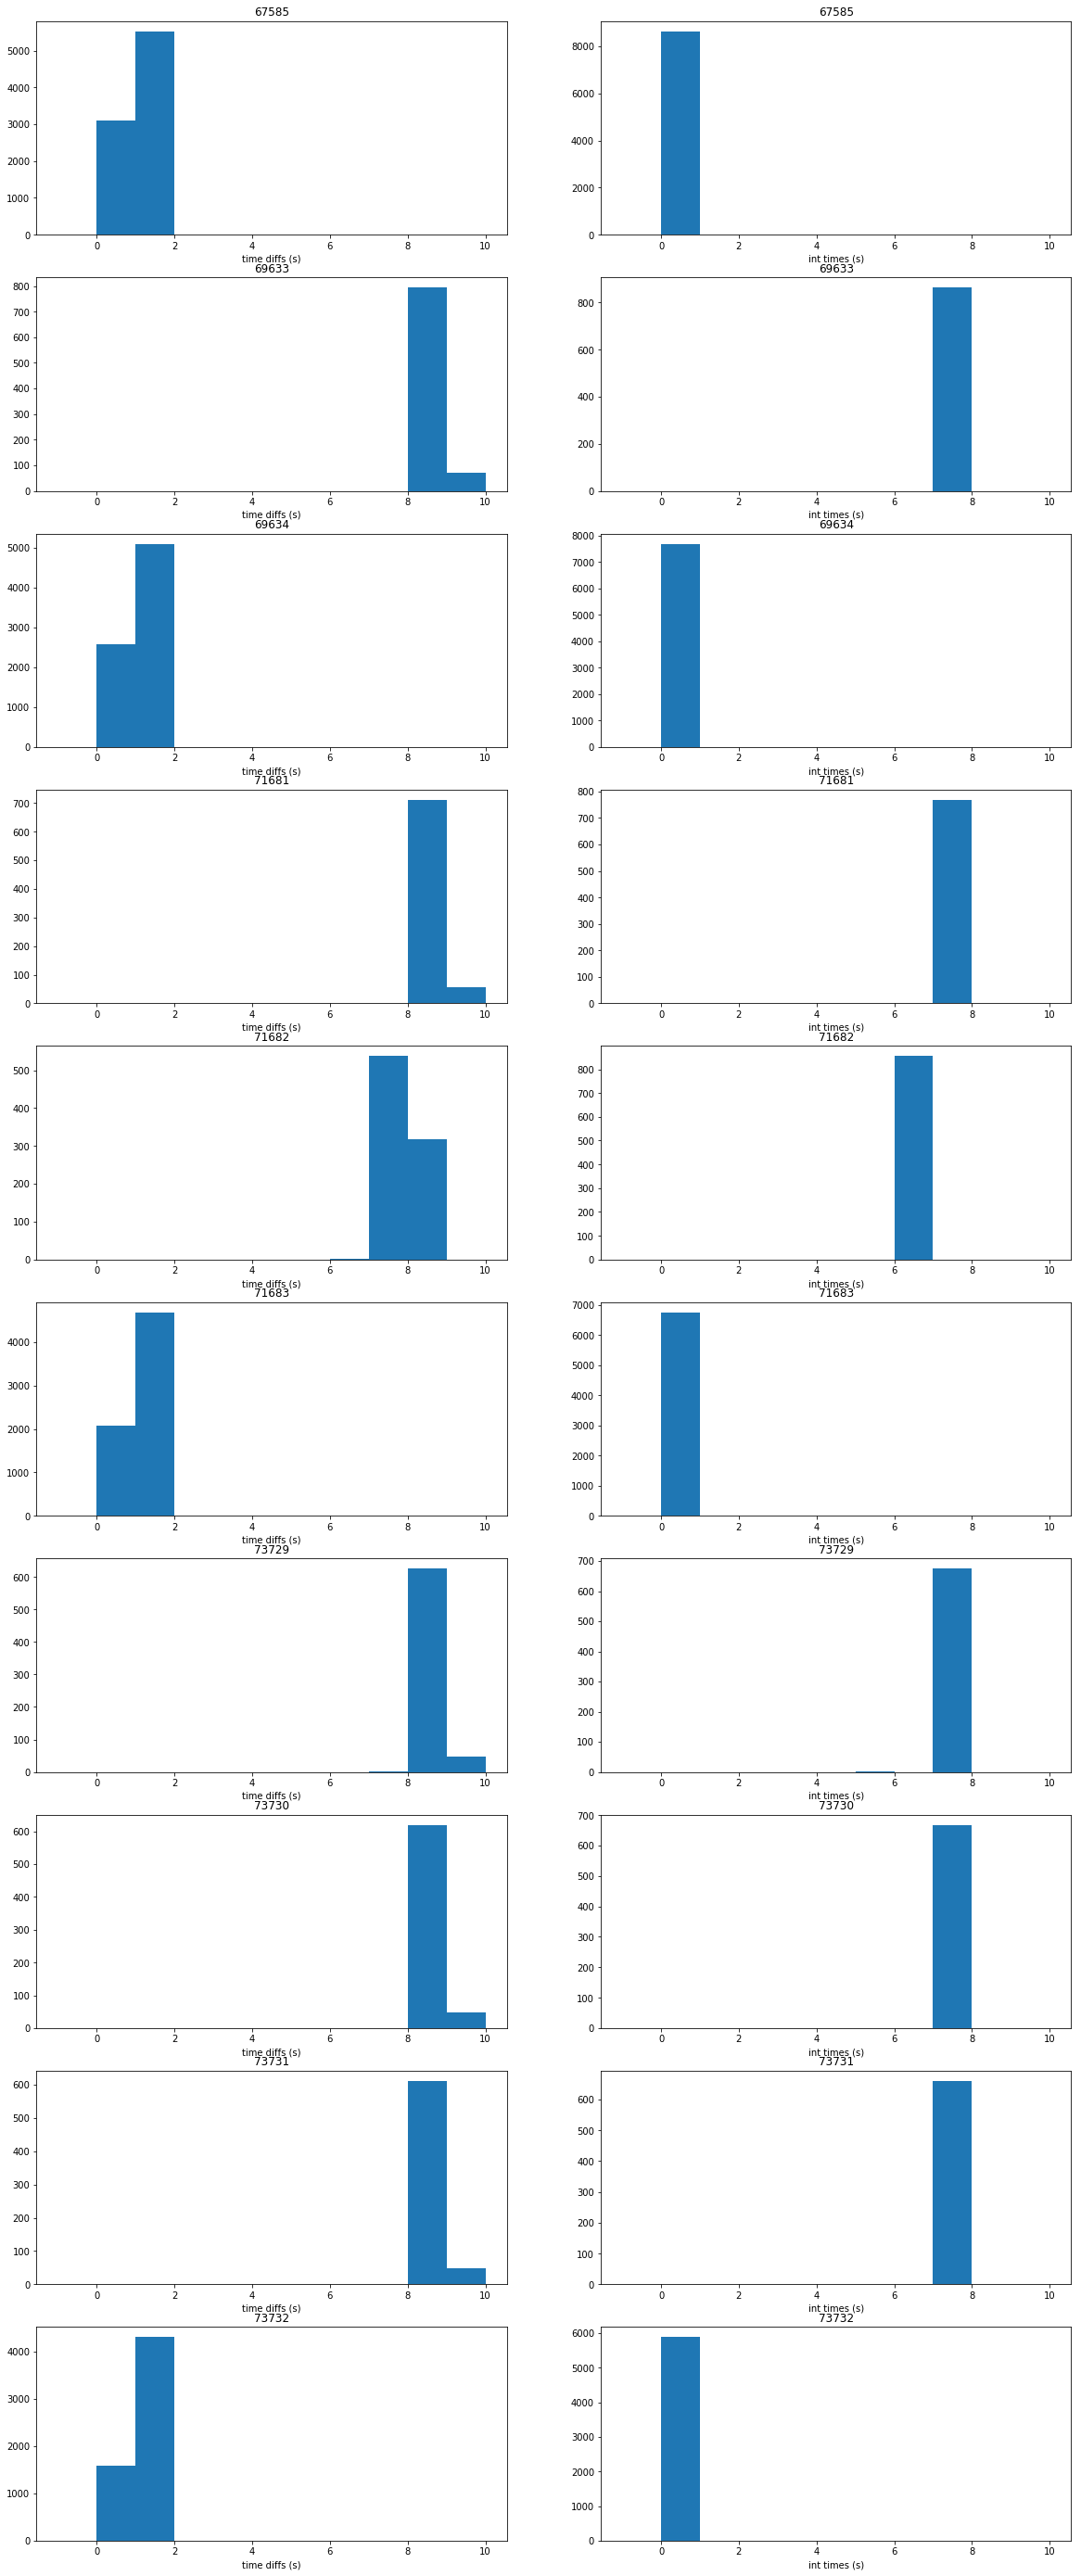

In [58]:
n_rows = unique_bls.size
plt.figure(figsize=(20,5*n_rows))
for index, bl in enumerate(unique_bls):
    print('baseline: ', bl)
    time_diffs = np.diff(np.sort(uv_bda.time_array[np.where(uv_bda.baseline_array == bl)]))*24*60*60
    int_times = uv_bda.integration_time[np.where(uv_bda.baseline_array == bl)]
    
    plt.subplot(n_rows, 2, 2*index+1)
    plt.hist(time_diffs, bins=np.arange(-1,11))
    plt.title(bl)
    plt.xlabel('time diffs (s)')

    plt.subplot(n_rows, 2, 2*index+2)
    plt.hist(int_times, bins=np.arange(-1,11))
    plt.title(bl)
    plt.xlabel('int times (s)')
    

plt.show()